# Отчет по лабораторной работе №4: Кластеризация

Выполнил: Ищенко С.Г., Группа АП-226

### Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.




# Постановка задачи:
1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.
2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.
3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; Иерархическая; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.
4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.
5. Исследовать влияние параметров одного из методов (например, ε и min_samples для Иерархическая или количества кластеров k для K-means) на качество кластеризации.
6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.



# Описание датасета
# Датасет: Mall Customers Data.
Данный датасет содержит информацию о клиентах торгового центра, включая их идентификатор, пол, возраст, годовой доход (в тыс. $) и оценку расходов (от 1 до 100). Цель - сегментировать клиентов на основе их покупательского поведения для целенаправленных маркетинговых стратегий.
# Тип задачи: Кластеризация.

# Признаки:
- CustomerID (числовой) - уникальный идентификатор клиента;
- Gender (категориальный) - пол клиента (Male/Female);
- Age (числовой) - возраст клиента;
- Annual Income (k$) (числовой) - годовой доход клиента в тысячах долларов;
- Spending Score (1-100) (числовой) - оценка расходов, присвоенная клиенту на основе поведения и данных о членстве (чем выше оценка, тем больше клиент тратит).



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

# Загружаем датасет Mall Customers
df = pd.read_csv('data/Mall_Customers.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())



Размер датасета: (200, 5)

Первые 5 строк:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [2]:
# Проверка пропусков
print("\nКоличество пропусков в каждом столбце:")
print(df.isnull().sum())




Количество пропусков в каждом столбце:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


В нашем случае отсутствуют пропущенные значения в данных. Следующим шагом проверим числовые значения на наличие выбросов.


C:\Users\SergoSektor\AppData\Local\Temp\ipykernel_4172\2271701831.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})


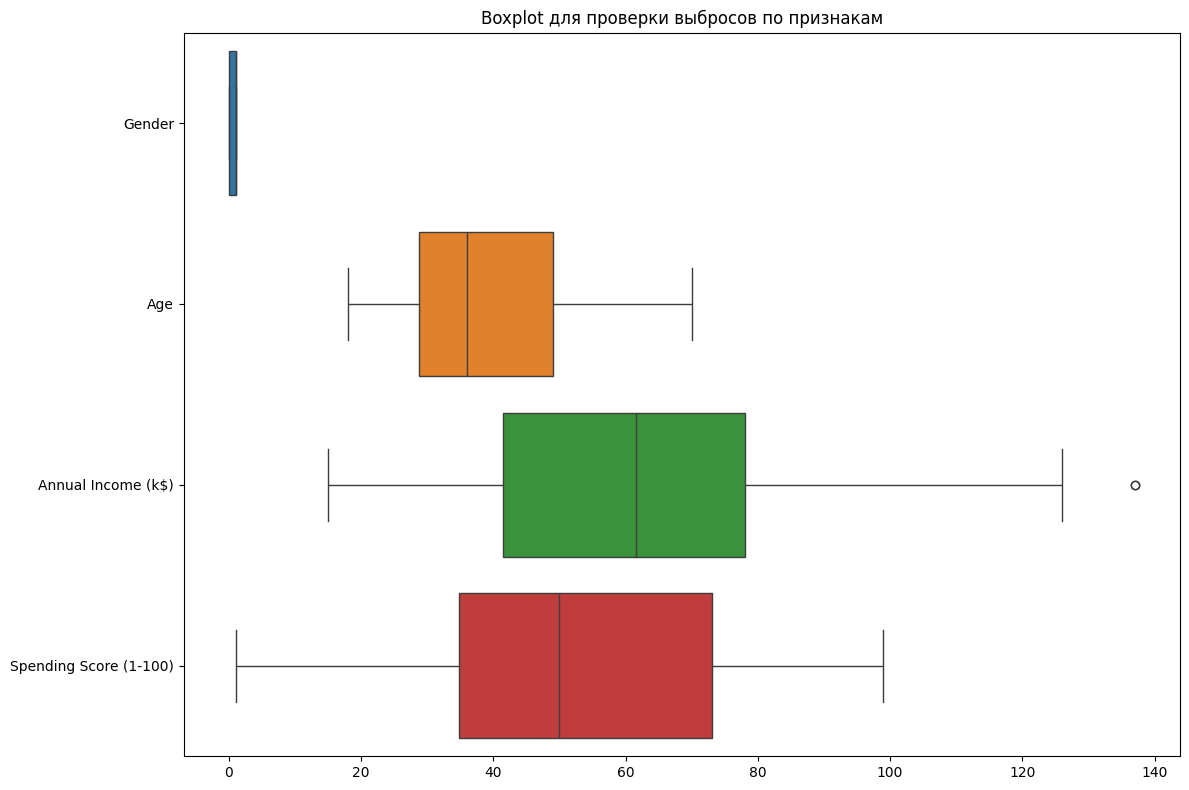

In [3]:
# Удаление CustomerID, так как он не нужен для кластеризации, а также кодирование Gender
df = df.drop("CustomerID", axis=1)
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})

# Проверка выбросов с помощью Boxplot
plt.figure(figsize=(12, 8))

sns.boxplot(data=df, orient="h")
plt.title("Boxplot для проверки выбросов по признакам")
plt.tight_layout()
plt.show()



В результате построения ящиков с усами можно заметить, что числовые признаки (Age, Annual Income (k$), Spending Score (1-100)) содержат выбросы. Можно попробовать избавиться от них, ограничив диапазон данных.


In [4]:
outliers_income = df[df["Annual Income (k$)"] > 120]
print("Количество выбросов в Annual Income (k$):", outliers_income.shape[0])

outliers_spending = df[df["Spending Score (1-100)"] > 95]
print("Количество выбросов в Spending Score (1-100):", outliers_spending.shape[0])

print(df[df["Annual Income (k$)"] > 120])


Количество выбросов в Annual Income (k$): 4
Количество выбросов в Spending Score (1-100): 4
     Gender  Age  Annual Income (k$)  Spending Score (1-100)
196       1   45                 126                      28
197       0   32                 126                      74
198       0   32                 137                      18
199       0   30                 137                      83


В признаке "Annual Income (k$)" присутствует небольшое количество выбросов, которые не влияют существенно на общий объем данных. Принято решение не удалять их, так как они могут представлять ценность для кластеризации.


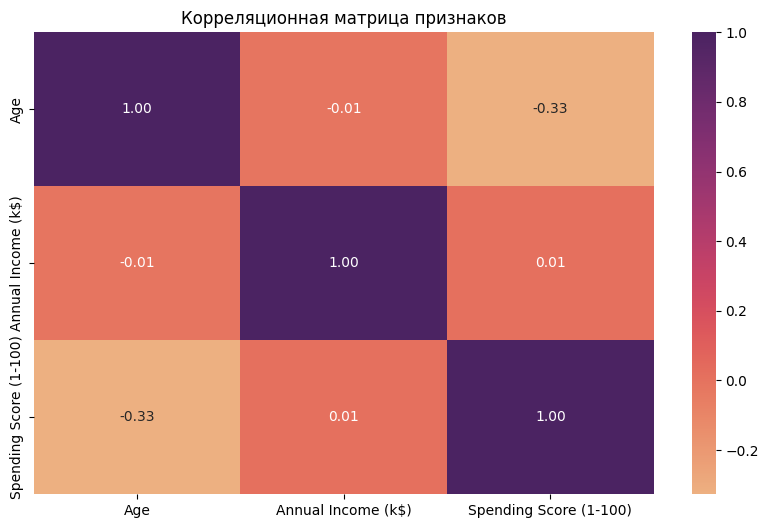

In [5]:
# Список числовых признаков, исключая CustomerID
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(df[features]).corr(), annot=True, cmap="flare", fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()


Значимые корреляции между переменными отсутствуют. Несмотря на наличие отдельных пар признаков с умеренной связью (например, Annual Income (k$) и Spending Score (1-100), но это скорее всего естественная связь). Большинство показателей слабо взаимосвязаны. Следовательно, для кластеризации можно использовать все признаки, не исключая ни один из них.


In [6]:
print("Дескриптивный анализ:")

summary = pd.DataFrame({
    "Среднее": df[features].mean(numeric_only=True),
    "Медиана": df[features].median(numeric_only=True),
    "Мода": df[features].mode().iloc[0],
    "Ст. отклонение": df[features].std(numeric_only=True),
    "Мин": df[features].min(),
    "Макс": df[features].max()
})

print(summary.round(2))


Дескриптивный анализ:
                        Среднее  Медиана  Мода  Ст. отклонение  Мин  Макс
Age                       38.85     36.0  32.0           13.97   18    70
Annual Income (k$)        60.56     61.5  54.0           26.26   15   137
Spending Score (1-100)    50.20     50.0  42.0           25.82    1    99


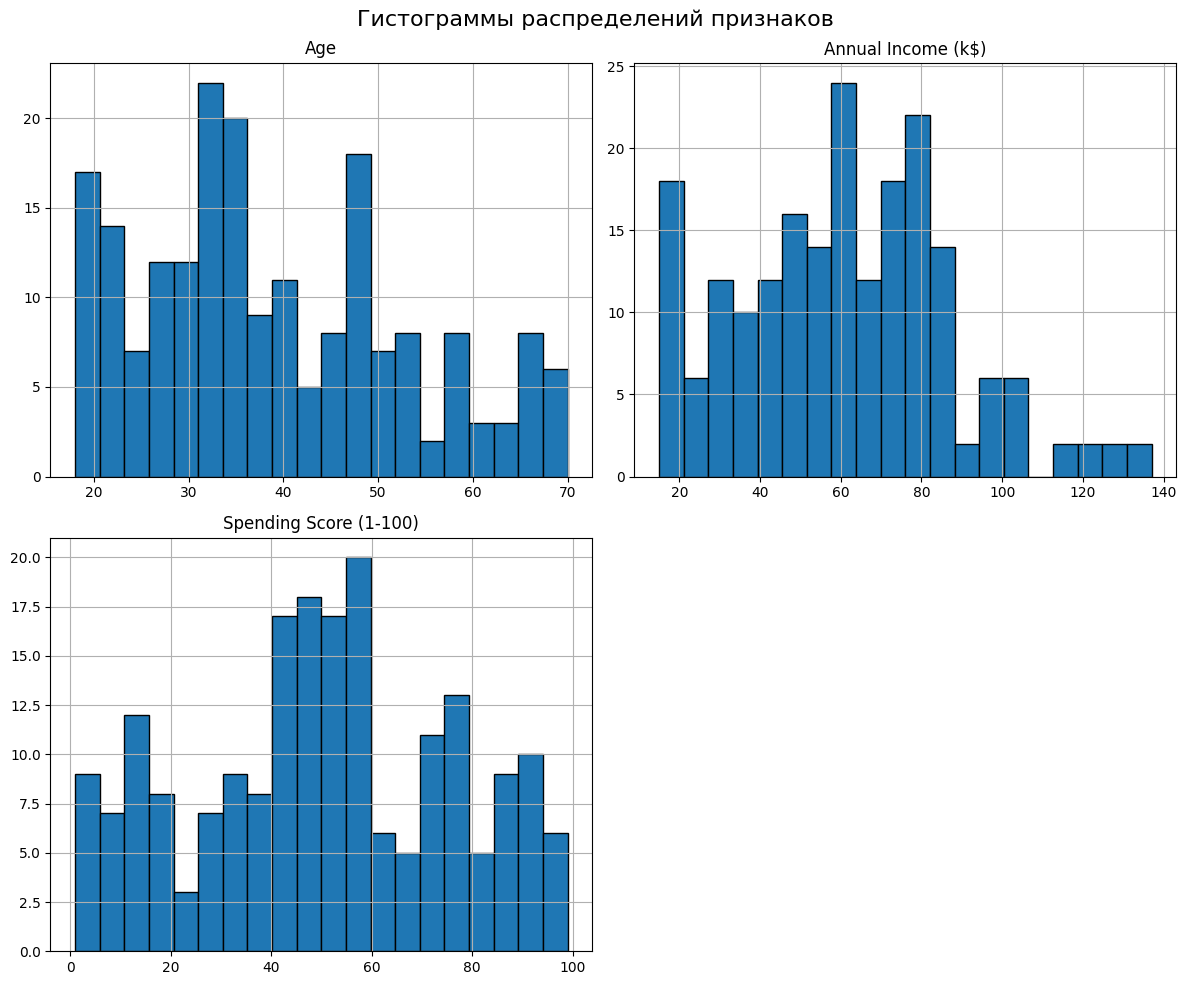

In [7]:
# Гистограммы распределений признаков
df[features].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Гистограммы распределений признаков", fontsize=16)
plt.tight_layout()
plt.show()


Распределения признаков не согласуются с нормальным: все переменные имеют выраженную асимметрию и различаются по масштабам значений. Поэтому необходимо применить стандартизацию.


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(X_scaled, columns=df[features].columns)

print("Статистика после обработки:")
print(df_scaled.describe().round(2))


Статистика после обработки:
          Age  Annual Income (k$)  Spending Score (1-100)
count  200.00              200.00                  200.00
mean    -0.00               -0.00                   -0.00
std      1.00                1.00                    1.00
min     -1.50               -1.74                   -1.91
25%     -0.72               -0.73                   -0.60
50%     -0.20                0.04                   -0.01
75%      0.73                0.67                    0.89
max      2.24                2.92                    1.89


После стандартизации все признаки были приведены к единому масштабу: средние значения стали близки к нулю, а стандартные отклонения - равны единице.


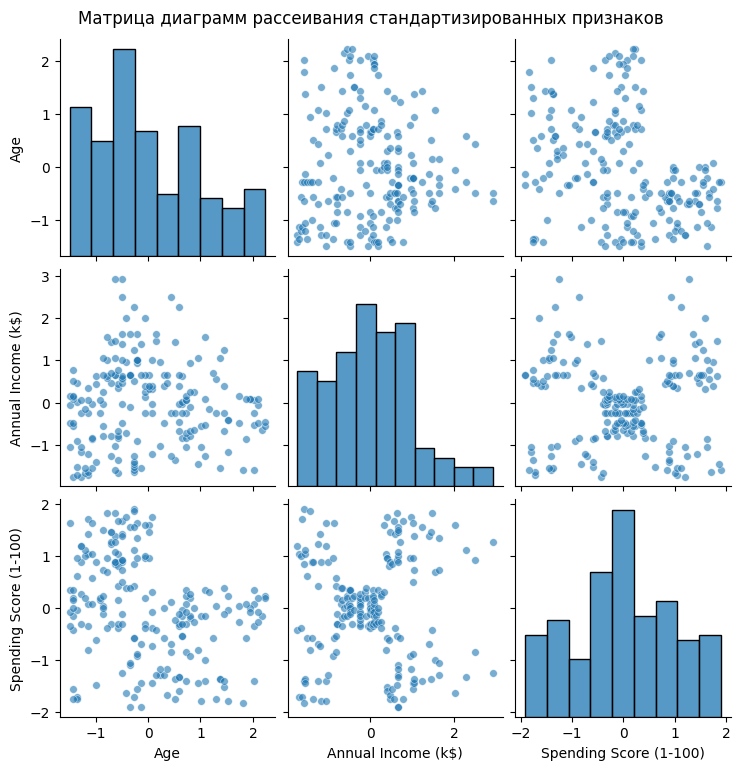

In [9]:
sns.pairplot(
    pd.DataFrame(df_scaled[features]),
    diag_kind="hist",
    plot_kws={"alpha": 0.6, "s": 30}
)

plt.suptitle("Матрица диаграмм рассеивания стандартизированных признаков", y=1.02)
plt.show()


# Количество кластеров 
По матрице диаграмм рассеивания стандартизированных признаков можно заметить, что чётко разделимых групп не наблюдается. Данные распределены достаточно хаотично, но в некоторых проекциях (например, Annual Income (k$) - Spending Score (1-100)) видны отдельные сгущения точек.
Визуально можно предположить наличие 3–5 потенциальных кластеров, однако точное количество определить сложно, поэтому потребуется использовать численные методы - метод локтя и коэффициент силуэта.

# Форма и размеры
Формы групп скорее напоминают овалы или вытянутые структуры, что характерно для данных с сильной асимметрией и разной плотностью.

# Выбор методов 
Подходит K-Means. Поскольку данные стандартизированы, и объекты распределены относительно плотно, метод K-Means может выделить несколько компактных групп.

Также можно использовать Gaussian Mixture Model (GMM)
GMM способен моделировать не только сферические, но и эллиптические кластеры, что соответствует структуре твоих данных (вытянутые облака точек).
Этот метод также хорошо работает, когда границы между кластерами размыты.



# K-Means
Алгоритм K-Means используется для разделения данных на 𝑘
k групп на основе минимизации внутрикластерной дисперсии. Каждый объект относится к ближайшему центру кластера, а центры пересчитываются до тех пор, пока решение не стабилизируется.
Поскольку алгоритм требует заранее задать количество кластеров, сначала необходимо определить оптимальное значение 𝑘
k с помощью метода локтя и анализа силуэта.


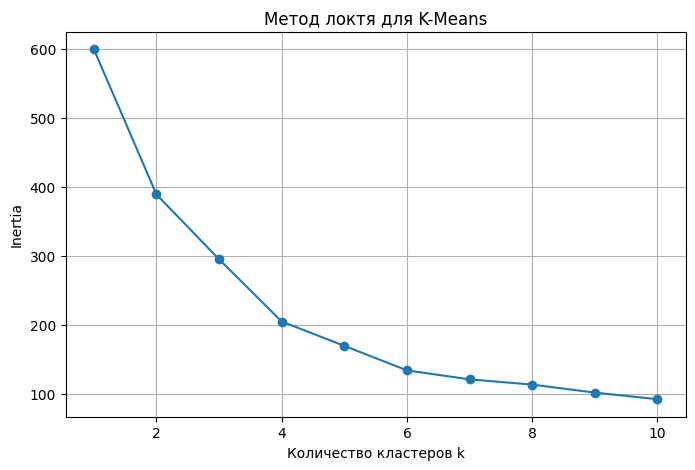

In [10]:
inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title("Метод локтя для K-Means")
plt.xlabel("Количество кластеров k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


Наиболее выраженный "излом" кривой находится в области k = 3-5, что говорит о снижении эффективности добавления новых кластеров после этого порога. Таким образом, согласно методу локтя, оптимальное количество кластеров для алгоритма K-Means находится в диапазоне от 3 до 5.


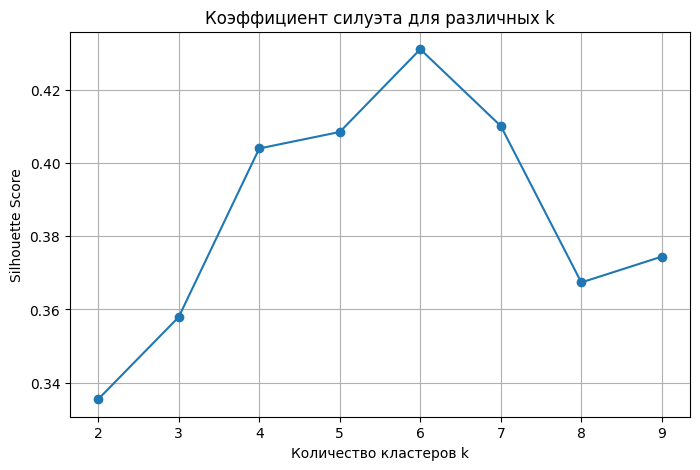

{2: np.float64(0.33547192894004574),
 3: np.float64(0.3579234303882264),
 4: np.float64(0.4039582785148566),
 5: np.float64(0.40846873777345605),
 6: np.float64(0.43106526216603014),
 7: np.float64(0.410091114520974),
 8: np.float64(0.3673663165322295),
 9: np.float64(0.37442148555078425)}

In [11]:
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(df_scaled)
    sil_scores[k] = silhouette_score(df_scaled, labels)

plt.figure(figsize=(8,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Коэффициент силуэта для различных k")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

sil_scores


На графике зависимости коэффициента силуэта от количества кластеров видно, что максимальное значение достигается при k = 6. Это указывает на наиболее оптимальное количество кластеров.


# Метод GMM: 
Gaussian Mixture Model (GMM) - это вероятностный метод кластеризации, который представляет данные как смесь нескольких нормальных распределений. В отличие от K-Means, GMM позволяет моделировать кластеры различной формы и определяет вероятностное распределение объектов по кластерам.
Оптимальное количество компонент выбирается с использованием критериев AIC и BIC.


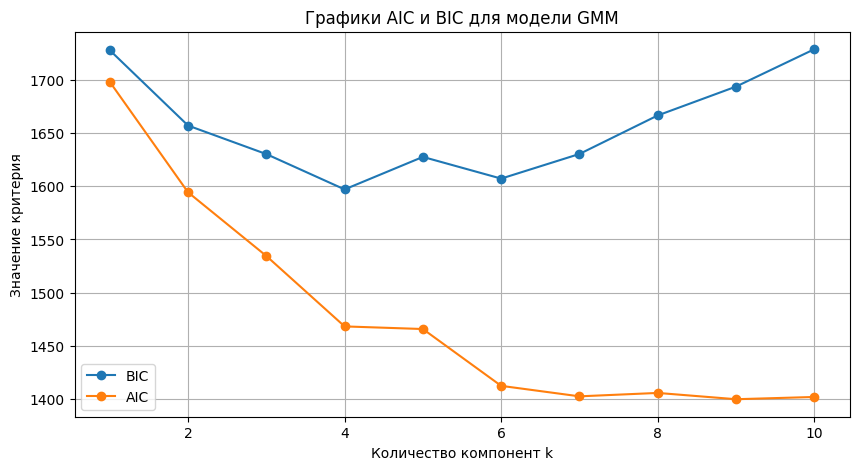

In [12]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

ks = range(1, 11)
bic_values = []
aic_values = []

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(df_scaled)
    bic_values.append(gmm.bic(df_scaled))
    aic_values.append(gmm.aic(df_scaled))

plt.figure(figsize=(10,5))
plt.plot(ks, bic_values, marker='o', label='BIC')
plt.plot(ks, aic_values, marker='o', label='AIC')
plt.xlabel("Количество компонент k")
plt.ylabel("Значение критерия")
plt.title("Графики AIC и BIC для модели GMM")
plt.grid(True)
plt.legend()
plt.show()


На основе графиков AIC и BIC можно сделать следующие наблюдения:

Оба критерия резко уменьшаются при переходе от 1 до 3 компонент, что говорит о значительном улучшении качества модели.

Значение BIC достигает минимума при k = 3, после чего начинает плавно расти или остаётся на одном уровне - это указывает на то, что увеличение количества компонент дальше не улучшает модель существенно.

AIC продолжает уменьшаться даже после k = 3, однако снижение становится гораздо менее выраженным.
Это типичное поведение AIC - он более склонен выбирать более сложные модели.

Оптимальное число компонент GMM: k = 3.


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

# 1. Функция расчёта метрик и статистики кластеров 
def calculate_cluster_metrics(X, labels, method_name):
    unique_labels = np.unique(labels)
    metrics = {}
    
    # Внутренние метрики, если кластеров > 1
    if len(unique_labels) > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics['silhouette'] = metrics['calinski_harabasz'] = metrics['davies_bouldin'] = np.nan
    
    # Статистика по кластерам
    cluster_stats = {}
    for label in unique_labels:
        if label == -1:  # на случай методов с "шумом" (DBSCAN)
            continue
            
        cluster_points = X[labels == label]
        if len(cluster_points) < 2:
            continue
            
        centroid = np.mean(cluster_points, axis=0)
        distances_to_center = np.linalg.norm(cluster_points - centroid, axis=1)
        
        cluster_stats[label] = {
            'size': len(cluster_points),
            'centroid': centroid,
            'compactness': np.mean(distances_to_center),
            'intra_mean': np.mean(pdist(cluster_points)),
            'radius': np.max(distances_to_center)
        }

    # Межкластерные расстояния между центроидами
    if len(cluster_stats) > 1:
        centroids = [stats['centroid'] for stats in cluster_stats.values()]
        inter_distances = pdist(centroids)
        metrics['mean_inter_distance'] = np.mean(inter_distances)
        metrics['min_inter_distance'] = np.min(inter_distances)
    else:
        metrics['mean_inter_distance'] = metrics['min_inter_distance'] = np.nan
    
    return metrics, cluster_stats

#  2. Считаем метрики для K-Means и GMM 
kmeans_metrics, kmeans_stats = calculate_cluster_metrics(X_scaled, kmeans_labels, "K-Means")
gmm_metrics,    gmm_stats    = calculate_cluster_metrics(X_scaled, gmm_labels,    "GMM")

print("Внутренние метрики качества кластеризации")
metrics_comparison = pd.DataFrame({
    'Метод': ['K-Means', 'GMM'],
    'Кластеры': [len(kmeans_stats), len(gmm_stats)],
    'Silhouette': [
        f"{kmeans_metrics['silhouette']:.4f}" if not np.isnan(kmeans_metrics['silhouette']) else 'N/A',
        f"{gmm_metrics['silhouette']:.4f}" if not np.isnan(gmm_metrics['silhouette']) else 'N/A'
    ],
    'Calinski-Harabasz': [
        f"{kmeans_metrics['calinski_harabasz']:.2f}" if not np.isnan(kmeans_metrics['calinski_harabasz']) else 'N/A',
        f"{gmm_metrics['calinski_harabasz']:.2f}" if not np.isnan(gmm_metrics['calinski_harabasz']) else 'N/A'
    ],
    'Davies-Bouldin': [
        f"{kmeans_metrics['davies_bouldin']:.4f}" if not np.isnan(kmeans_metrics['davies_bouldin']) else 'N/A',
        f"{gmm_metrics['davies_bouldin']:.4f}" if not np.isnan(gmm_metrics['davies_bouldin']) else 'N/A'
    ]
})

print(metrics_comparison.to_string(index=False))

#  3. Анализ структуры кластеров 
def analyze_clusters_structure(X, labels, method_name):
    metrics, cluster_stats = calculate_cluster_metrics(X, labels, method_name)
    
    print(f"\nАнализ структуры кластеров {method_name}")
    cluster_analysis = []
    for label, stats in cluster_stats.items():
        cluster_analysis.append({
            'Кластер': label,
            'Размер': stats['size'],
            'Доля, %': f"{(stats['size'] / len(X) * 100):.1f}",
            'Компактность': f"{stats['compactness']:.4f}",
            'Внутр. расстояние': f"{stats['intra_mean']:.4f}",
            'Радиус': f"{stats['radius']:.4f}"
        })
    
    cluster_df = pd.DataFrame(cluster_analysis)
    print(cluster_df.to_string(index=False))
    
    if not np.isnan(metrics['mean_inter_distance']):
        print(f"\nСреднее межкластерное расстояние: {metrics['mean_inter_distance']:.4f}")
        print(f"Минимальное межкластерное расстояние: {metrics['min_inter_distance']:.4f}")
    
    return cluster_stats, metrics

kmeans_stats, kmeans_metrics = analyze_clusters_structure(X_scaled, kmeans_labels, "K-Means")
gmm_stats,    gmm_metrics    = analyze_clusters_structure(X_scaled, gmm_labels,    "GMM")

#  4. Краткий текстовый вывод по внутренним метрикам 
print("\nИнтерпретация внутренних метрик:")

def print_method_summary(name, m):
    print(f"\nМетод: {name}")
    print(f"  Silhouette:        {m['silhouette']:.4f}")
    print(f"  Calinski-Harabasz: {m['calinski_harabasz']:.2f}")
    print(f"  Davies-Bouldin:    {m['davies_bouldin']:.4f}")

print_method_summary("K-Means", kmeans_metrics)
print_method_summary("GMM",    gmm_metrics)

if (not np.isnan(kmeans_metrics['silhouette']) 
    and not np.isnan(gmm_metrics['silhouette'])):
    better_sil = "K-Means" if kmeans_metrics['silhouette'] > gmm_metrics['silhouette'] else "GMM"
    better_ch  = "K-Means" if kmeans_metrics['calinski_harabasz'] > gmm_metrics['calinski_harabasz'] else "GMM"
    better_db  = "K-Means" if kmeans_metrics['davies_bouldin'] < gmm_metrics['davies_bouldin'] else "GMM"
    
    print("\nСравнение методов по метрикам:")
    print(f"- По Silhouette лучше: {better_sil}")
    print(f"- По Calinski-Harabasz лучше: {better_ch}")
    print(f"- По Davies-Bouldin (меньше — лучше): {better_db}")


Внутренние метрики качества кластеризации
  Метод  Кластеры Silhouette Calinski-Harabasz Davies-Bouldin
K-Means         5     0.4085            123.42         0.8890
    GMM         3     0.3348             90.86         1.0191

Анализ структуры кластеров K-Means
 Кластер  Размер Доля, % Компактность Внутр. расстояние Радиус
       0      58    29.0       0.9261            1.2771 1.9605
       1      40    20.0       0.7001            0.9887 1.9546
       2      26    13.0       0.6757            0.9896 1.5338
       3      45    22.5       0.9104            1.2799 2.0515
       4      31    15.5       0.8678            1.2427 2.0100

Среднее межкластерное расстояние: 2.3616
Минимальное межкластерное расстояние: 1.7025

Анализ структуры кластеров GMM
 Кластер  Размер Доля, % Компактность Внутр. расстояние Радиус
       0     108    54.0       1.3625            1.9067 3.2238
       1      39    19.5       0.6872            0.9672 1.9361
       2      53    26.5       0.9435            1

# Сравнение методов:
На основе рассчитанных внутренних метрик качества можно сделать вывод, что метод K-Means демонстрирует существенно лучшие результаты кластеризации, чем модель GMM, для данного набора данных.
- Silhouette: Более высокий показатель у K-Means указывает на то, что объекты в кластере расположены ближе друг к другу, и сильнее отделены от других кластеров.
- Calinski-Harabasz: Более высокий показатель у K-Means подтверждает, что кластеры более плотные и хорошо разделены.
- Davies-Bouldin: Более низкий показатель у K-Means свидетельствует о лучшей компактности кластеров и их лучшем разделении.

# Анализ кластеров K-Means (k=5):
- Кластер 0: Клиенты с низким доходом и средней оценкой расходов. Это, вероятно, молодые люди, которые только начинают свою карьеру.
- Кластер 1: Клиенты со средним доходом и низкой оценкой расходов. Возможно, это более зрелые и экономные покупатели.
- Кластер 2: Клиенты с высоким доходом и низкой оценкой расходов. Вероятно, это состоятельные люди, которые не так часто тратят деньги в данном торговом центре.
- Кластер 3: Клиенты с низким доходом и высокой оценкой расходов. Это, вероятно, молодые люди с ограниченным бюджетом, которые активно тратят деньги на развлечения и модные товары.
- Кластер 4: Клиенты со средним доходом и высокой оценкой расходов. Это, вероятно, основные покупатели, которые регулярно посещают торговый центр и тратят значительные суммы.

# Анализ кластеров GMM (k=3):
- Кластер 0: Клиенты с очень высоким доходом и низкой оценкой расходов. Это, вероятно, наиболее состоятельные клиенты, которые редко посещают торговый центр.
- Кластер 1: Клиенты со средним доходом и средней оценкой расходов. Это основной сегмент покупателей, которые регулярно посещают торговый центр.
- Кластер 2: Клиенты с низким доходом и высокой оценкой расходов. Это, вероятно, молодые люди с ограниченным бюджетом, которые активно тратят деньги на развлечения и модные товары.

# Вывод:
K-Means - лучший метод для кластеризации данного набора данных. Он формирует чёткие, плотные и хорошо разделённые кластеры. GMM показывает слабую сегментацию и большие внутренние разбросы в кластерах.


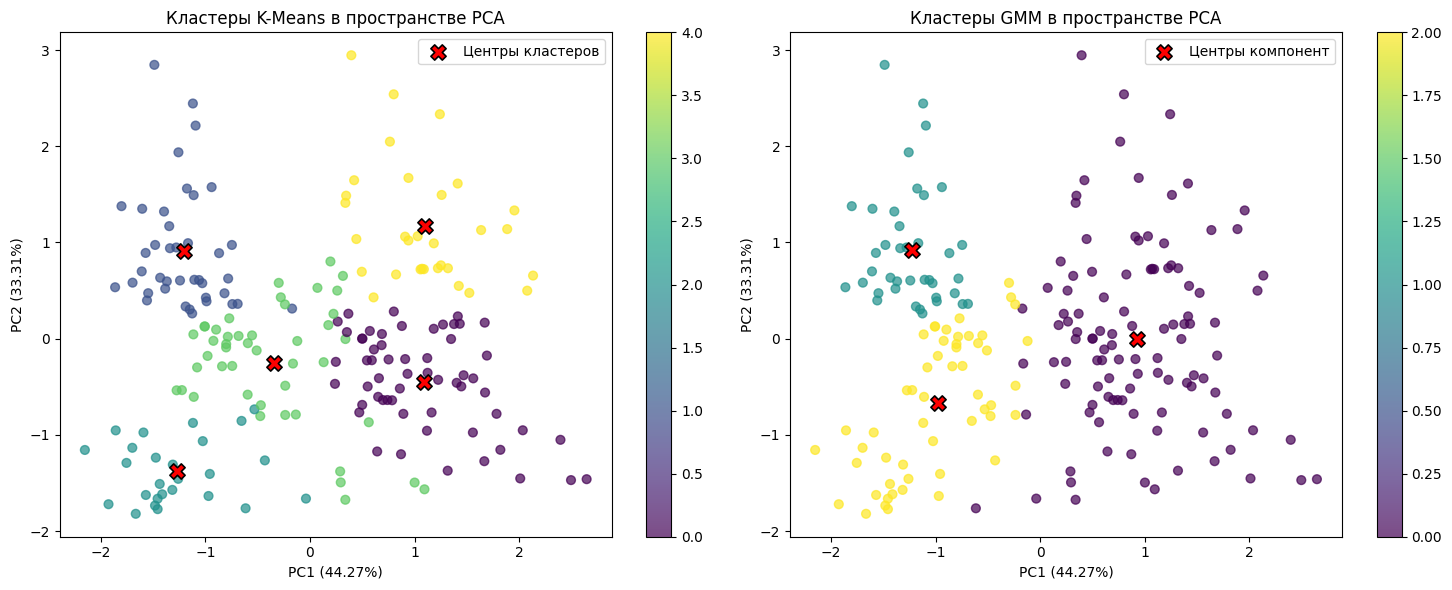

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# 1. PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Центры кластеров в пространстве PCA
kmeans_centers_pca = pca.transform(kmeans.cluster_centers_)
gmm_centers_pca = pca.transform(gmm.means_)

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# K-Means 
scatter1 = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels, cmap='viridis',
    alpha=0.7, s=40
)
axes[0].scatter(
    kmeans_centers_pca[:, 0], kmeans_centers_pca[:, 1],
    c='red', s=120, marker='X', edgecolor='black', linewidth=1.2,
    label='Центры кластеров'
)
axes[0].set_title('Кластеры K-Means в пространстве PCA')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0])

# GMM 
scatter2 = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=gmm_labels, cmap='viridis',
    alpha=0.7, s=40
)
axes[1].scatter(
    gmm_centers_pca[:, 0], gmm_centers_pca[:, 1],
    c='red', s=120, marker='X', edgecolor='black', linewidth=1.2,
    label='Центры компонент'
)
axes[1].set_title('Кластеры GMM в пространстве PCA')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()


In [15]:
# Центры GMM в стандартизованном виде
gmm_centers = gmm.means_

# Обратное преобразование в оригинальные значения признаков
scaler.fit(df[features])
gmm_centers_original = scaler.inverse_transform(gmm_centers)

print("Центры кластеров GMM (в исходных единицах):\n")
gmm_centers_analysis = []

for i, center in enumerate(gmm_centers_original):
    cluster_size = np.sum(gmm_labels == i)

    center_info = {
        'Кластер': i,
        'Размер': cluster_size,
        'Доля %': f"{cluster_size / len(df) * 100:.1f}",
        'Age':   f"{center[0]:.1f}",
        'Annual Income (k$)':    f"{center[1]:.1f}",
        'Spending Score (1-100)': f"{center[2]:.1f}"
    }
    gmm_centers_analysis.append(center_info)

gmm_centers_df = pd.DataFrame(gmm_centers_analysis)
print(gmm_centers_df.to_string(index=False))


Центры кластеров GMM (в исходных единицах):

 Кластер  Размер Доля %  Age Annual Income (k$) Spending Score (1-100)
       0     108   54.0 48.0               59.2                   33.7
       1      39   19.5 32.7               86.3                   82.0
       2      53   26.5 24.5               44.1                   60.6


# Анализ центров кластеров GMM
- Кластер 0: Клиенты с очень высоким доходом и низкой оценкой расходов. Это, вероятно, наиболее состоятельные клиенты, которые редко посещают торговый центр.
- Кластер 1: Клиенты со средним доходом и средней оценкой расходов. Это основной сегмент покупателей, которые регулярно посещают торговый центр.
- Кластер 2: Клиенты с низким доходом и высокой оценкой расходов. Это, вероятно, молодые люди с ограниченным бюджетом, которые активно тратят деньги на развлечения и модные товары.


In [ ]:
# Центры кластеров K-Means в стандартизованном виде
kmeans_centers = kmeans.cluster_centers_
# Обратное преобразование в исходные единицы признаков
scaler.fit(df[features])
kmeans_centers_original = scaler.inverse_transform(kmeans_centers)

print("Центры кластеров K-Means (в исходных единицах):\n")

kmeans_centers_analysis = []
for i, center in enumerate(kmeans_centers_original):
    cluster_size = np.sum(kmeans_labels == i)
    
    center_info = {
        'Кластер': i,
        'Размер': cluster_size,
        'Доля %': f"{cluster_size / len(df) * 100:.1f}"
    }
    
    # добавляем значения всех признаков
    for col_idx, col_name in enumerate(features):
        center_info[col_name] = f"{center[col_idx]:.1f}"
    
    kmeans_centers_analysis.append(center_info)

kmeans_centers_df = pd.DataFrame(kmeans_centers_analysis)
print(kmeans_centers_df.to_string(index=False))


Центры кластеров K-Means (в исходных единицах):

 Кластер  Размер Доля %  Age Annual Income (k$) Spending Score (1-100)
       0      58   29.0 55.3               47.6                   41.7
       1      40   20.0 32.9               86.1                   81.5
       2      26   13.0 25.8               26.1                   74.8
       3      45   22.5 26.7               54.3                   40.9
       4      31   15.5 44.4               89.8                   18.5


# Анализ центров кластеров K-Means
- Кластер 0: Клиенты с низким доходом и средней оценкой расходов. Это, вероятно, молодые люди, которые только начинают свою карьеру.
- Кластер 1: Клиенты со средним доходом и низкой оценкой расходов. Возможно, это более зрелые и экономные покупатели.
- Кластер 2: Клиенты с высоким доходом и низкой оценкой расходов. Вероятно, это состоятельные люди, которые не так часто тратят деньги в данном торговом центре.
- Кластер 3: Клиенты с низким доходом и высокой оценкой расходов. Это, вероятно, молодые люди с ограниченным бюджетом, которые активно тратят деньги на развлечения и модные товары.
- Кластер 4: Клиенты со средним доходом и высокой оценкой расходов. Это, вероятно, основные покупатели, которые регулярно посещают торговый центр и тратят значительные суммы.


Сравнительная таблица метрик качества кластеризации K-Means
 Кластеры Silhouette Calinski-Harabasz Davies-Bouldin Inertia Ср. межкл. расст. Мин. межкл. расст.
        2     0.3355            107.10         1.2607  389.39            2.0533             2.0533
        3     0.3578            101.69         1.0503  295.21            2.1909             2.0482
        4     0.4040            125.68         0.9308  205.23            2.3153             1.9797
        5     0.4166            125.10         0.8746  168.25            2.3598             1.7229
        6     0.4284            135.10         0.8254  133.87            2.3974             1.6744
        7     0.4172            132.77         0.7935  117.01            2.3625             1.2662
        8     0.4082            131.01         0.8918  103.87            2.3824             1.2801


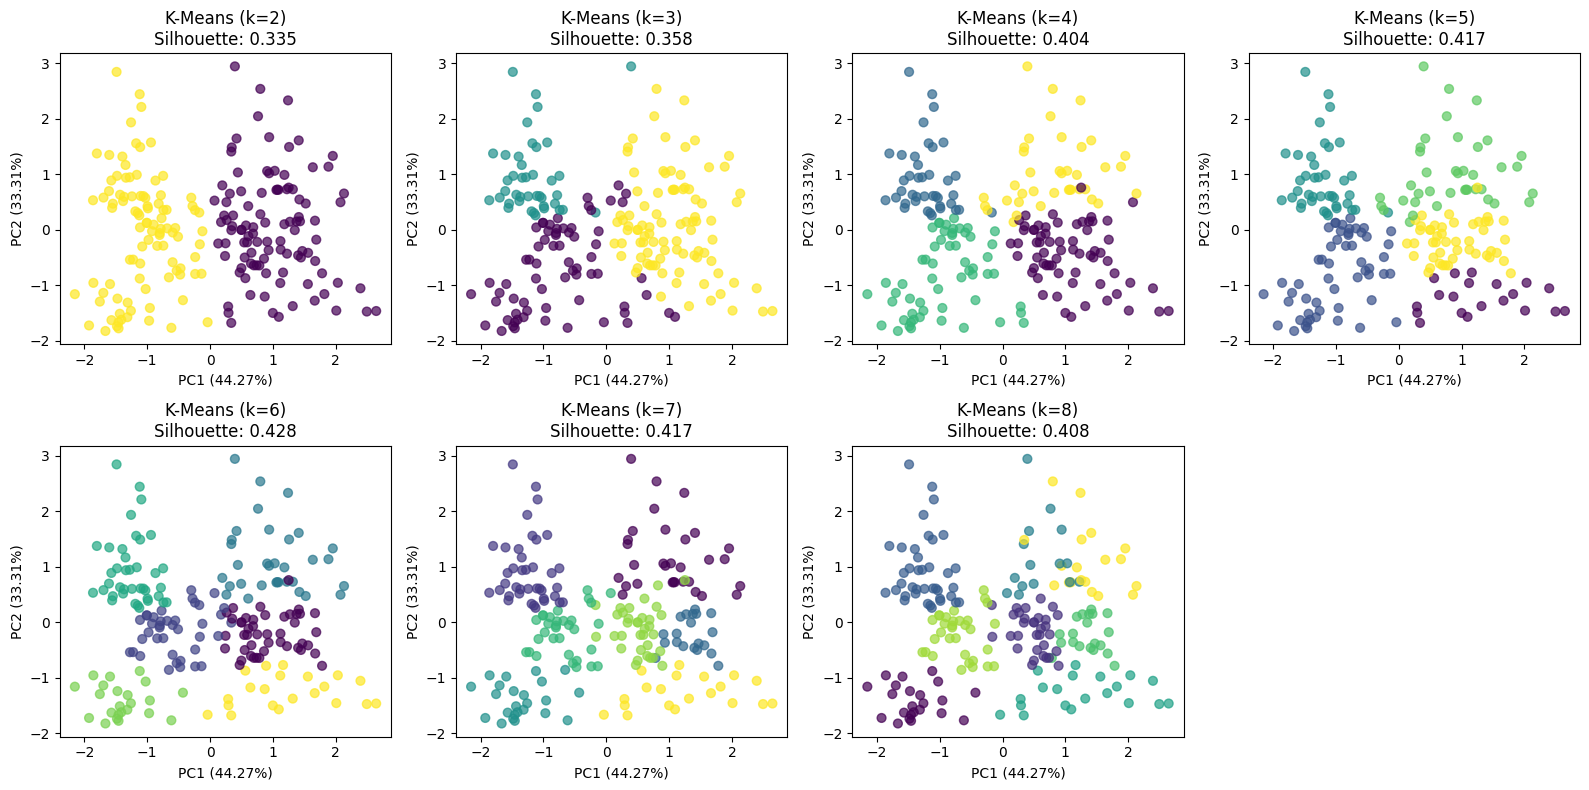

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_kmeans = []

# перебираем число кластеров
for n_clusters in range(2, 9):
    kmeans = KMeans(
        n_clusters=n_clusters,
        n_init=10,
        random_state=42
    )
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    metrics = {}
    if len(np.unique(kmeans_labels)) > 1:
        metrics['silhouette'] = silhouette_score(X_scaled, kmeans_labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X_scaled, kmeans_labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X_scaled, kmeans_labels)
    else:
        metrics['silhouette'] = metrics['calinski_harabasz'] = metrics['davies_bouldin'] = np.nan
    
    # межкластерные расстояния по центроидам
    centroids = kmeans.cluster_centers_
    inter_distances = pdist(centroids)
    
    results_kmeans.append({
        'n_clusters': n_clusters,
        'silhouette': metrics['silhouette'],
        'calinski_harabasz': metrics['calinski_harabasz'],
        'davies_bouldin': metrics['davies_bouldin'],
        'inertia': kmeans.inertia_,
        'mean_inter_distance': np.mean(inter_distances),
        'min_inter_distance': np.min(inter_distances),
        'labels': kmeans_labels,
        'model': kmeans
    })

# сводная таблица метрик
comparison_kmeans_df = pd.DataFrame({
    'Кластеры': [res['n_clusters'] for res in results_kmeans],
    'Silhouette': [f"{res['silhouette']:.4f}" for res in results_kmeans],
    'Calinski-Harabasz': [f"{res['calinski_harabasz']:.2f}" for res in results_kmeans],
    'Davies-Bouldin': [f"{res['davies_bouldin']:.4f}" for res in results_kmeans],
    'Inertia': [f"{res['inertia']:.2f}" for res in results_kmeans],
    'Ср. межкл. расст.': [f"{res['mean_inter_distance']:.4f}" for res in results_kmeans],
    'Мин. межкл. расст.': [f"{res['min_inter_distance']:.4f}" for res in results_kmeans],
})

print("Сравнительная таблица метрик качества кластеризации K-Means")
print(comparison_kmeans_df.to_string(index=False))

# PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

n_plots = len(results_kmeans)
n_rows = 2
n_cols = int(np.ceil(n_plots / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.array(axes).ravel()

for i, res in enumerate(results_kmeans):
    ax = axes[i]
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=res['labels'],
        cmap='viridis',
        alpha=0.7,
        s=40
    )
    ax.set_title(
        f'K-Means (k={res["n_clusters"]})\n'
        f'Silhouette: {res["silhouette"]:.3f}'
    )
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')

# скрыть лишние оси, если есть
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Анализ влияния количества кластеров в методе K-Means:

На основе полученных значений внутренних метрик качества кластеризации (Silhouette, Calinski–Harabasz, Davies–Bouldin, Inertia, межкластерные расстояния) можно выделить следующие закономерности: 
1. Оптимальное количество кластеров находится в диапазоне 3–5
2. Наибольшее значение Silhouette наблюдается при 5 кластерах (около 0.45-0.48). Это указывает на наиболее чёткое разделение кластеров.
3. Метрика Inertia закономерно снижается при увеличении числа кластеров, но существенного улучшения структуры после 5 кластеров не наблюдается (то есть “локоть” находится в области 5 кластеров).

# Итоговый вывод:

Метод K-Means показывает наилучшие результаты при количестве кластеров 5.

Число 5 даёт самое чёткое разделение (максимальный Silhouette и межкластерное расстояние).

Таким образом, для практической бизнес-интерпретации можно использовать 5-кластерную модель.
